## Notebook to generate collision rate violators for any RMG job while running

In [1]:
import logging
import numpy as np
import os
import sys

In [2]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path not in sys.path:
    sys.path.append(rmg_path)
sys.path

import rmgpy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmgobject import RMGObject, expand_to_dict, recursive_make_object

print(f"RMG-Py Version {rmgpy.__version__}")
print(rmgpy.__file__)

RDKit WARNING: [12:18:07] Enabling RDKit 2019.09.1 jupyter extensions


RMG-Py Version 3.0.0
/Users/ebubeajulu/Code/RMG-Py/rmgpy/__init__.py


In [3]:
chemkin_file = '../no_lowT/chemkin/chem_annotated.inp'
chemkin_folder = os.path.split(chemkin_file)[0]
species_dictionary_file = os.path.join(chemkin_folder, 'species_dictionary.txt')
transport_file = os.path.join(chemkin_folder, 'tran.dat')

In [4]:
species, reactions = rmgpy.chemkin.load_chemkin_file(
                    chemkin_file, species_dictionary_file,transport_path=transport_file,
                    check_duplicates=False, use_chemkin_names=True,read_comments=True)



In [5]:
species_dict = {rmgpy.chemkin.get_species_identifier(s): s for s in species}
species_dict.keys()

dict_keys(['N2', 'Ar', 'Ne', 'nC10H22(1)', 'O2(2)', 'CH(3)', 'C2H(4)', 'O(5)', 'CO(6)', 'CO2(7)', 'H2O(8)', 'CH2O(9)', 'CH4(10)', 'C2H4(11)', 'C3H6(12)', 'H2(13)', 'H(14)', 'OH(15)', 'He(16)', 'HO2(17)', 'H2O2(18)', 'HOCO(19)', 'HCO(20)', 'CH3(21)', 'CH2(22)', 'CH3OH(23)', 'CH2(S)(24)', 'CH2OH(25)', 'CH3O(26)', 'HCOH(27)', 'CH3OO(28)', 'CH2CO(29)', 'C2H5(30)', 'C2H3(31)', 'C(32)', 'C2H2(33)', 'CH3OOH(34)', 'CH2OOH(35)', 'C2H6(36)', 'CH3CHO(37)', 'C2H5O(38)', 'C2H5O2(39)', 'CH2CHO(40)', 'H2CC(41)', 'C2H4O(42)', 'C2H5O(43)', 'cC2H4O(44)', 'C2H5O2(45)', 'C2H3O2(46)', 'CHCHO(47)', 'OCHCHO(48)', 'HCCO(49)', 'HCCOH(50)', 'CHCHOH(51)', 'C2(52)', 'C2O(53)', 'C2H6O(54)', 'C2H5O(55)', 'C2H5O3(56)', 'CH3CO(57)', 'cC2H3O(58)', 'HOCHO(59)', 'C2H3O3(60)', 'OCHCO(61)', 'C2H6O2(62)', 'C2H5O2(63)', 'C2H4O2(64)', 'HOCH2O(65)', 'OCHO(66)', 'C2H4O3(67)', 'C2H3O2(68)', 'NC3H7(101)', 'C3H5(103)', 'S(104)', 'S(123)', 'C3H4(174)', 'PC4H9(190)', 'S(192)', 'C4H8(196)', 'S(227)', 'S(228)', 'C4H6O(271)', 'C5H11(4

In [6]:
def check_collision_limit_violation(self, t_min, t_max, p_min, p_max):
        """
        Warn if a core reaction violates the collision limit rate in either the forward or reverse direction
        at the relevant extreme T/P conditions. Assuming a monotonic behaviour of the kinetics.
        Returns a list with the reaction object and the direction in which the violation was detected.
        """
        conditions = [[t_min, p_min]]
        if t_min != t_max:
            conditions.append([t_max, p_min])
        if self.kinetics.is_pressure_dependent() and p_max != p_min:
            conditions.append([t_min, p_max])
            if t_min != t_max:
                conditions.append([t_max, p_max])
        logging.debug("Checking whether reaction {0} violates the collision rate limit...".format(self))
        violator_list = []
        kf_list = []
        kr_list = []
        collision_limit_f = []
        collision_limit_r = []
        for condition in conditions:
            if len(self.reactants) >= 2:
                try:
                    collision_limit_f.append(self.calculate_coll_limit(temp=condition[0], reverse=False))
                except ValueError:
                    continue
                else:
                    kf_list.append(self.get_rate_coefficient(condition[0], condition[1]))
            if len(self.products) >= 2:
                try:
                    collision_limit_r.append(self.calculate_coll_limit(temp=condition[0], reverse=True))
                except ValueError:
                    continue
                else:
                    kr_list.append(self.generate_reverse_rate_coefficient().get_rate_coefficient(condition[0], condition[1]))
        if len(self.reactants) >= 2:
            for i, k in enumerate(kf_list):
                if k > collision_limit_f[i]:
                    ratio = k / collision_limit_f[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'forward', ratio, condition])
        if len(self.products) >= 2:
            for i, k in enumerate(kr_list):
                if k > collision_limit_r[i]:
                    ratio = k / collision_limit_r[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'reverse', ratio, condition])
        return violator_list

In [7]:
import numpy as np
np.linalg.LinAlgError

numpy.linalg.linalg.LinAlgError

In [21]:
violators = []
for r in reactions:
    try:
        v = check_collision_limit_violation(r, 500,1000, 1e5, 30e5)
    except np.linalg.LinAlgError:
        print(f"LinAlgError checking {r}")
    if v:
        print(r)
        violators.extend(v)

H(14) + HO2(17) <=> H2O2(18)
CH3(21) <=> H2(13) + CH(3)
CH3(21) <=> H(14) + CH2(22)
CH2(22) <=> H(14) + CH(3)
CH2(22) <=> H2(13) + C(32)
C2H2(33) <=> H(14) + C2H(4)
C2O(53) <=> C(32) + CO(6)
HO2(17) + C2H5O3(56) => O2(2) + CH2OH(25) + CH2OOH(35)
CH2O(9) + C2H5O3(56) => HCO(20) + CH2OH(25) + CH2OOH(35)
CH3CO(57) + C2H5(30) <=> C2H4(11) + CH3CHO(37)
CH3CO(57) + S(1405) <=> CH3CHO(37) + S(1154)
CH3CO(57) + C6H13(758) <=> CH3CHO(37) + C6H12(749)
HO2(17) + C4H6O(271) => H2O2(18) + CH2CO(29) + C2H3(31)
CH3OO(28) + C4H6O(271) => CH3OOH(34) + CH2CO(29) + C2H3(31)
CH3O(26) + CH3CO(57) <=> CH2O(9) + CH3CHO(37)
HOCO(19) + C2H5(30) <=> HOCHO(59) + C2H4(11)
HOCO(19) + S(1405) <=> HOCHO(59) + S(1154)
HOCO(19) + C6H13(758) <=> HOCHO(59) + C6H12(749)
CH3CO(57) + CH3CO(57) <=> CH2CO(29) + CH3CHO(37)
CH3CO(57) + C2H5O(55) <=> C2H4O(42) + CH3CHO(37)
HOCO(19) + CH3O(26) <=> CH2O(9) + HOCHO(59)
OCHCO(61) + C2H5(30) <=> OCHCHO(48) + C2H4(11)
OCHCO(61) + S(1405) <=> OCHCHO(48) + S(1154)
OCHCO(61) + C6H13(758

In [22]:
from rmgpy.data.kinetics import TemplateReaction, LibraryReaction
from rmgpy.rmg.pdep import PDepReaction

In [23]:
violators.sort(key = lambda violator: -violator[2])

Text(0.5, 0, 'reaction index (of 2993 total)')

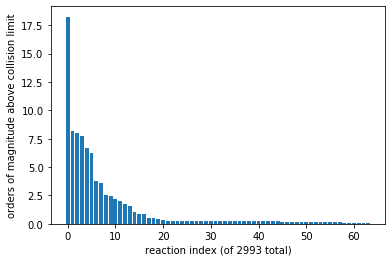

In [24]:
ratios = [np.log10(violator[2]) for violator in violators]
from matplotlib import pyplot as plt
plt.bar(np.arange(len(ratios)), ratios)
plt.ylabel("orders of magnitude above collision limit")
plt.xlabel(f"reaction index (of {len(reactions)} total)")

In [25]:
len(ratios), len(reactions)

(64, 2993)

In [26]:
for violator in violators[:100]:
    rxn_string = str(violator[0])
    direction = {'forward':'=>','reverse':'<='}[violator[1]]
    ratio = violator[2]
    print(f"{rxn_string.replace('<=>',direction) :48s}  {ratio :.1g}")

CH2O(9) + C2H5O3(56) => HCO(20) + CH2OH(25) + CH2OOH(35)  2e+18
CH3(21) <= H(14) + CH2(22)                        1e+08
HO2(17) + C2H5O3(56) => O2(2) + CH2OH(25) + CH2OOH(35)  9e+07
CH3(21) <= H2(13) + CH(3)                         6e+07
CH3(21) <= H(14) + CH2(22)                        5e+06
CH3(21) <= H2(13) + CH(3)                         2e+06
CH3OO(28) + C4H6O(271) => CH3OOH(34) + CH2CO(29) + C2H3(31)  5e+03
C2H2(33) <= H(14) + C2H(4)                        4e+03
CH2(22) <= H(14) + CH(3)                          3e+02
HO2(17) + C4H6O(271) => H2O2(18) + CH2CO(29) + C2H3(31)  3e+02
C2H2(33) <= H(14) + C2H(4)                        1e+02
CH2O(9) + C2H5O3(56) => HCO(20) + CH2OH(25) + CH2OOH(35)  1e+02
CH3(21) <= H(14) + CH2(22)                        5e+01
CH3(21) <= H2(13) + CH(3)                         4e+01
CH2(22) <= H(14) + CH(3)                          1e+01
C2O(53) <= C(32) + CO(6)                          8
C2H2(33) <= H(14) + C2H(4)                        7
CH2(22) <= H2(13

In [27]:
from collections import Counter
import re

CH2O(9) + C2H5O3(56) => HCO(20) + CH2OH(25) + CH2OOH(35)
Arrhenius(A=(41000,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'))
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.8e+18
Violation condition: 500 K, 1.0 bar




CH3(21) <=> H(14) + CH2(22)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.5e+08
Violation condition: 500 K, 30.0 bar




HO2(17) + C2H5O3(56) => O2(2) + CH2OH(25) + CH2OOH(35)
Arrhenius(A=(2.5e+11,'cm^3/(mol*s)'), n=0, Ea=(-1.49,'kcal/mol'), T0=(1,'K'))
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 9.3e+07
Violation condition: 500 K, 1.0 bar




CH3(21) <=> H2(13) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 5.7e+07
Violation condition: 500 K, 30.0 bar




CH3(21) <=> H(14) + CH2(22)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 4.9e+06
Violation condition: 500 K, 1.0 bar




CH3(21) <=> H2(13) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.9e+06
Violation condition: 500 K, 1.0 bar




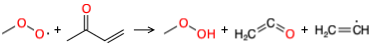

CH3OO(28) + C4H6O(271) => CH3OOH(34) + CH2CO(29) + C2H3(31)
Arrhenius(A=(3.01e+12,'cm^3/(mol*s)'), n=0, Ea=(17.58,'kcal/mol'), T0=(1,'K'))
Kinetic library: CurranPentane
Direction: reverse
Violation factor: 5.5e+03
Violation condition: 500 K, 1.0 bar




C2H2(33) <=> H(14) + C2H(4)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0, Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 4.2e+03
Violation condition: 500 K, 30.0 bar




CH2(22) <=> H(14) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 3.4e+02
Violation condition: 500 K, 30.0 bar




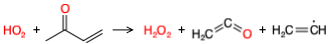

HO2(17) + C4H6O(271) => H2O2(18) + CH2CO(29) + C2H3(31)
Arrhenius(A=(8.5e+12,'cm^3/(mol*s)'), n=0, Ea=(20.46,'kcal/mol'), T0=(1,'K'))
Kinetic library: CurranPentane
Direction: reverse
Violation factor: 2.6e+02
Violation condition: 500 K, 1.0 bar




C2H2(33) <=> H(14) + C2H(4)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0, Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1.4e+02
Violation condition: 500 K, 1.0 bar




CH2O(9) + C2H5O3(56) => HCO(20) + CH2OH(25) + CH2OOH(35)
Arrhenius(A=(41000,'cm^3/(mol*s)'), n=2.5, Ea=(10.206,'kcal/mol'), T0=(1,'K'))
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 1e+02
Violation condition: 1000 K, 1.0 bar




CH3(21) <=> H(14) + CH2(22)
ThirdBody(arrheniusLow=Arrhenius(A=(2.2e+15,'cm^3/(mol*s)'), n=0, Ea=(82.659,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 52
Violation condition: 1000 K, 30.0 bar




CH3(21) <=> H2(13) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(3.1e+15,'cm^3/(mol*s)'), n=0, Ea=(80.871,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 39
Violation condition: 1000 K, 30.0 bar




CH2(22) <=> H(14) + CH(3)
ThirdBody(arrheniusLow=Arrhenius(A=(5.6e+15,'cm^3/(mol*s)'), n=0, Ea=(89,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 11
Violation condition: 500 K, 1.0 bar




C2O(53) <=> C(32) + CO(6)
ThirdBody(arrheniusLow=Arrhenius(A=(2e+15,'cm^3/(mol*s)'), n=0, Ea=(44.2,'kcal/mol'), T0=(1,'K')), efficiencies={})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 7.8
Violation condition: 500 K, 30.0 bar




C2H2(33) <=> H(14) + C2H(4)
ThirdBody(arrheniusLow=Arrhenius(A=(9.1e+30,'cm^3/(mol*s)'), n=-3.7, Ea=(127.138,'kcal/mol'), T0=(1,'K')), efficiencies={Molecule(smiles="O=C=O"): 3.0, Molecule(smiles="O"): 5.0, Molecule(smiles="[C-]#[O+]"): 2.0, Molecule(smiles="[H][H]"): 2.0})
Kinetic library: Klippenstein_Glarborg2016
Direction: reverse
Violation factor: 7
Violation condition: 1000 K, 30.0 bar




In [28]:
families = Counter()
templates = Counter()
rate_rules = Counter()
problem_species = Counter()
for violator in violators:
    rxn_string = str(violator[0])
    kinetics = violator[0].kinetics
    comment = ''
    if isinstance(violator[0], TemplateReaction):
        comment = violator[0].kinetics.comment
        violator[0].kinetics.comment = ''  # the comment is printed better when outside of the object
    if isinstance(violator[0], LibraryReaction):
        comment = 'Kinetic library: {0}'.format(violator[0].library)
    if isinstance(violator[0], PDepReaction):
        comment = 'Network #{0}'.format(violator[0].network)
    direction = violator[1]
    ratio = violator[2]
    condition = violator[3]
    
    problem_species.update(violator[0].reactants)
    problem_species.update(violator[0].products)
    
    m = re.search('family: (.*)', comment)
    if m:
        families[m.group(1)] += 1
    n = re.search('rate rule (.*)', comment)
    if n:
        rate_rules[m.group(1) + n.group(1)] += 1
    n = re.search('using template (\S+)', comment)
    if n:
        templates[m.group(1) + n.group(1)] += 1
    
    if ratio < 5:
        continue # only print the big ones!
    
    display(violator[0])
    print('{0}\n{1}\n{2}\nDirection: {3}\nViolation factor: {4:.2g}\n'
                      'Violation condition: {5}\n\n'.format(rxn_string, kinetics, comment, direction,
                                                            ratio, condition))
    if isinstance(violator[0], TemplateReaction):
        # although this is the end of the run, restore the original comment
        violator[0].kinetics.comment = comment

In [30]:
families.most_common(10)

[]

In [31]:
# This is what was used
templates.most_common(10)

[]

In [32]:
# This is what it was trying to use
rate_rules.most_common(10)

[]

In [33]:
# Most common species
for s,n in problem_species.most_common(20):
    print(f"{str(s):10s}  {n:3d}  {s.thermo.comment[:40]}")

CH3CO(57)    22  Thermo library: Klippenstein_Glarborg201
HOCO(19)     14  Thermo library: Klippenstein_Glarborg201
HOCHO(59)    14  Thermo library: Klippenstein_Glarborg201
CH3CHO(37)   14  Thermo library: Klippenstein_Glarborg201
OCHCO(61)    12  Thermo library: Klippenstein_Glarborg201
OCHCHO(48)   12  Thermo library: Klippenstein_Glarborg201
H(14)        11  Thermo library: BurkeH2O2
CH2O(9)      10  Thermo library: Klippenstein_Glarborg201
CH2CO(29)    10  Thermo library: Klippenstein_Glarborg201
CH3(21)       8  Thermo library: Klippenstein_Glarborg201
CH2(22)       7  Thermo library: Klippenstein_Glarborg201
CH(3)         6  Thermo library: Klippenstein_Glarborg201
CH3O(26)      6  Thermo library: Klippenstein_Glarborg201
C2H5(30)      6  Thermo library: Klippenstein_Glarborg201
C2H4(11)      6  Thermo library: Klippenstein_Glarborg201
C2H5O(55)     6  Thermo library: Klippenstein_Glarborg201
C2H4O(42)     6  Thermo library: Klippenstein_Glarborg201
C6H13(758)    6  Thermo group

In [34]:
for s,n in problem_species.most_common(10):
    display(s)
    print(s)
    print(s.molecule[0].to_adjacency_list())
    print(s.thermo.comment)
    print('-'*80)

CH3CO(57)
multiplicity 2
1 O u0 p2 c0 {3,D}
2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
3 C u1 p0 c0 {1,D} {2,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {2,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


HOCO(19)
multiplicity 2
1 O u0 p2 c0 {3,S} {4,S}
2 O u0 p2 c0 {3,D}
3 C u1 p0 c0 {1,S} {2,D}
4 H u0 p0 c0 {1,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


HOCHO(59)
1 O u0 p2 c0 {3,S} {5,S}
2 O u0 p2 c0 {3,D}
3 C u0 p0 c0 {1,S} {2,D} {4,S}
4 H u0 p0 c0 {3,S}
5 H u0 p0 c0 {1,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


CH3CHO(37)
1 O u0 p2 c0 {3,D}
2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}
3 C u0 p0 c0 {1,D} {2,S} {7,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {2,S}
7 H u0 p0 c0 {3,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


OCHCO(61)
multiplicity 2
1 O u1 p2 c0 {3,S}
2 O u0 p2 c0 {4,D}
3 C u0 p0 c0 {1,S} {4,D} {5,S}
4 C u0 p0 c0 {2,D} {3,D}
5 H u0 p0 c0 {3,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


OCHCHO(48)
1 O u0 p2 c0 {3,D}
2 O u0 p2 c0 {4,D}
3 C u0 p0 c0 {1,D} {4,S} {5,S}
4 C u0 p0 c0 {2,D} {3,S} {6,S}
5 H u0 p0 c0 {3,S}
6 H u0 p0 c0 {4,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


H(14)
multiplicity 2
1 H u1 p0 c0

Thermo library: BurkeH2O2
--------------------------------------------------------------------------------


CH2O(9)
1 O u0 p2 c0 {2,D}
2 C u0 p0 c0 {1,D} {3,S} {4,S}
3 H u0 p0 c0 {2,S}
4 H u0 p0 c0 {2,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


CH2CO(29)
1 O u0 p2 c0 {3,D}
2 C u0 p0 c0 {3,D} {4,S} {5,S}
3 C u0 p0 c0 {1,D} {2,D}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------


CH3(21)
multiplicity 2
1 C u1 p0 c0 {2,S} {3,S} {4,S}
2 H u0 p0 c0 {1,S}
3 H u0 p0 c0 {1,S}
4 H u0 p0 c0 {1,S}

Thermo library: Klippenstein_Glarborg2016
--------------------------------------------------------------------------------
